In [ ]:
import os
import tensorflow as tf

save_dir_bert = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/BERT2/'
train_dataset_bert_path = os.path.join(save_dir_bert, 'train_tf_dataset')
val_dataset_bert_path = os.path.join(save_dir_bert, 'val_tf_dataset')
test_dataset_bert_path = os.path.join(save_dir_bert, 'test_tf_dataset')

save_dir_cnn = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/data_tf/'
train_dataset_cnn_path = os.path.join(save_dir_cnn, 'train_tf_dataset_ID')
val_dataset_cnn_path = os.path.join(save_dir_cnn, 'val_tf_dataset_ID')
test_dataset_cnn_path = os.path.join(save_dir_cnn, 'test_tf_dataset_ID')

train_dataset_bert = tf.data.Dataset.load(train_dataset_bert_path).prefetch(tf.data.AUTOTUNE)
val_dataset_bert = tf.data.Dataset.load(val_dataset_bert_path).prefetch(tf.data.AUTOTUNE)
test_dataset_bert = tf.data.Dataset.load(test_dataset_bert_path).prefetch(tf.data.AUTOTUNE)

train_dataset_cnn = tf.data.Dataset.load(train_dataset_cnn_path).prefetch(tf.data.AUTOTUNE)
val_dataset_cnn = tf.data.Dataset.load(val_dataset_cnn_path).prefetch(tf.data.AUTOTUNE)
test_dataset_cnn = tf.data.Dataset.load(test_dataset_cnn_path).prefetch(tf.data.AUTOTUNE)

print(f"Nombre d'images dans le dataset d'entraînement BERT: {len(train_dataset_bert)}")
print(f"Nombre d'images dans le dataset de validation BERT: {len(val_dataset_bert)}")
print(f"Nombre d'images dans le dataset de test BERT: {len(test_dataset_bert)}")

print(f"Nombre d'images dans le dataset d'entraînement CNN: {len(train_dataset_cnn)}")
print(f"Nombre d'images dans le dataset de validation CNN: {len(val_dataset_cnn)}")
print(f"Nombre d'images dans le dataset de test CNN: {len(test_dataset_cnn)}")

Nombre d'images dans le dataset d'entraînement BERT: 320000
Nombre d'images dans le dataset de validation BERT: 40000
Nombre d'images dans le dataset de test BERT: 39999
Nombre d'images dans le dataset d'entraînement CNN: 10000
Nombre d'images dans le dataset de validation CNN: 1250
Nombre d'images dans le dataset de test CNN: 1250


In [ ]:
from tqdm import tqdm

def create_image_id_mapping_bert(dataset):
    dataset_dict = {}
    total = tf.data.experimental.cardinality(dataset).numpy()
    if total == tf.data.experimental.INFINITE_CARDINALITY:
        total = None

    # Ajouter la barre de progression tqdm
    for inputs, label in tqdm(dataset, total=total, desc='Création du mapping image_ID pour BERT'):
        # Les labels sont scalaires, pas de dimension de batch
        image_ID = inputs['image_ID'].numpy().decode('utf-8')
        data = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }
        dataset_dict[image_ID] = (data, label)
    return dataset_dict


In [ ]:
from tqdm import tqdm

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def create_image_id_mapping_cnn(dataset):
    dataset_dict = {}
    total = tf.data.experimental.cardinality(dataset).numpy()
    if total == tf.data.experimental.INFINITE_CARDINALITY:
        total = None

    for batch in tqdm(dataset, total=total, desc='Création du mapping image_ID pour CNN'):
        images_batch, labels_batch, image_IDs_batch = batch  # Le batch est un tuple de trois éléments

        batch_size = labels_batch.shape[0]
        for i in range(batch_size):
            image = images_batch[i]
            label = labels_batch[i]
            image_ID = image_IDs_batch[i].numpy().decode('utf-8')

            data = {
                'image': image,
            }

            dataset_dict[image_ID] = (data, label)
    return dataset_dict


Physical devices cannot be modified after being initialized


In [ ]:
from tqdm import tqdm
import tensorflow as tf
import gc

def create_image_id_mapping_cnn_non_batched(dataset):
    dataset_dict = {}
    total = tf.data.experimental.cardinality(dataset).numpy()
    if total == tf.data.experimental.INFINITE_CARDINALITY:
        total = None

    for sample in tqdm(dataset, total=total, desc='Création du mapping image_ID pour CNN'):
        image, label, image_ID = sample  # Chaque sample est un tuple de trois éléments

        image = image.numpy()  # Convertir en NumPy (CPU)
        label = label.numpy()  # Convertir en NumPy (CPU)
        image_ID = image_ID.numpy().decode('utf-8')

        data = {
            'image': image,
        }

        dataset_dict[image_ID] = (data, label)

        # Supprimer explicitement les variables inutilisées
        del image, label, image_ID, sample, data

        # Forcer la collecte des objets inutilisés
        gc.collect()

    return dataset_dict


In [ ]:
def merge_datasets(bert_dict, cnn_dict):
    merged_data = []
    for image_ID in bert_dict.keys():
        if image_ID in cnn_dict:
            bert_data, bert_label = bert_dict[image_ID]
            cnn_data, cnn_label = cnn_dict[image_ID]

            # Vérifier que les labels sont identiques
            if bert_label != cnn_label:
                print(f"Avertissement : labels différents pour image_ID {image_ID}")

            merged_inputs = {
                'input_ids': bert_data['input_ids'],
                'attention_mask': bert_data['attention_mask'],
                'image': cnn_data['image'],
                'image_ID': image_ID,
            }
            label = bert_label  # On peut choisir l'un ou l'autre, ils devraient être identiques

            merged_data.append((merged_inputs, label))
    return merged_data


In [ ]:
def create_tf_dataset_from_merged_data(merged_data):
    def generator():
        for inputs, label in merged_data:
            yield inputs, label

    output_signature = (
        {
            'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32),
            'image': tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32),
            'image_ID': tf.TensorSpec(shape=(), dtype=tf.string),
        },
        tf.TensorSpec(shape=(), dtype=tf.int64)  # Label en dehors des inputs
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset


In [ ]:
import pickle

# Fonction pour sauvegarder le dictionnaire
def save_dataset_dict_pickle(dataset_dict, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(dataset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Fonction pour charger le dictionnaire
def load_dataset_dict_pickle(filename):
    with open(filename, 'rb') as handle:
        dataset_dict = pickle.load(handle)
    return dataset_dict


In [ ]:
save_dir_merged = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/'

# Créer le répertoire s'il n'existe pas
if not os.path.exists(save_dir_merged):
    os.makedirs(save_dir_merged)

# Création des mappings
unbatched_train_dataset_cnn = train_dataset_cnn.unbatch()
train_dataset_cnn_dict = create_image_id_mapping_cnn_non_batched(unbatched_train_dataset_cnn)

train_dataset_cnn_dict_path = os.path.join(save_dir_merged, 'train_dataset_cnn_dict2.pkl')
save_dataset_dict_pickle(train_dataset_cnn_dict, train_dataset_cnn_dict_path)

Création du mapping image_ID pour CNN: 320000it [06:55, 769.37it/s] 


In [ ]:
save_dir_merged ='/content/result/'
train_dataset_cnn_dict_path = os.path.join(save_dir_merged, 'train_dataset_cnn_dict4.pkl')
save_dataset_dict_pickle(train_dataset_cnn_dict, train_dataset_cnn_dict_path)


In [ ]:
!cp '/content/result/train_dataset_cnn_dict4.pkl' '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/'

cp: error writing '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/train_dataset_cnn_dict4.pkl': No space left on device


In [ ]:
import gc
gc.collect()


0

In [ ]:


save_dir_merged = '/content/result/'
train_dataset_cnn_dict_path = os.path.join(save_dir_merged, 'train_dataset_cnn_dict4.pkl')
train_dataset_cnn_dict = load_dataset_dict_pickle(train_dataset_cnn_dict_path)

train_dataset_bert_dict = create_image_id_mapping_bert(train_dataset_bert)


# Fusion des datasets
merged_train_data = merge_datasets(train_dataset_bert_dict, train_dataset_cnn_dict)

# Création du dataset final
final_train_dataset = create_tf_dataset_from_merged_data(merged_train_data)



Création du mapping image_ID pour BERT: 100%|██████████| 320000/320000 [01:38<00:00, 3263.01it/s]


In [ ]:
# Définir les chemins pour enregistrer les datasets fusionnés
save_dir_merged = '/content/result/'

# Créer le répertoire s'il n'existe pas
if not os.path.exists(save_dir_merged):
    os.makedirs(save_dir_merged)
merged_train_dataset_path = os.path.join(save_dir_merged, 'merged_train_dataset')
final_train_dataset.save(merged_train_dataset_path)

In [ ]:
# Datasets de validation
val_dataset_bert_dict = create_image_id_mapping_bert(val_dataset_bert)
unbatched_val_dataset_cnn = val_dataset_cnn.unbatch()
val_dataset_cnn_dict = create_image_id_mapping_cnn_non_batched(unbatched_val_dataset_cnn)
merged_val_data = merge_datasets(val_dataset_bert_dict, val_dataset_cnn_dict)
final_val_dataset = create_tf_dataset_from_merged_data(merged_val_data)

# Datasets de test
test_dataset_bert_dict = create_image_id_mapping_bert(test_dataset_bert)
unbatched_test_dataset_cnn = test_dataset_cnn.unbatch()
test_dataset_cnn_dict = create_image_id_mapping_cnn_non_batched(unbatched_test_dataset_cnn)
merged_test_data = merge_datasets(test_dataset_bert_dict, test_dataset_cnn_dict)
final_test_dataset = create_tf_dataset_from_merged_data(merged_test_data)


Création du mapping image_ID pour BERT: 100%|██████████| 40000/40000 [00:11<00:00, 3483.15it/s]
Création du mapping image_ID pour CNN: 40000it [01:42, 390.44it/s]
Création du mapping image_ID pour BERT: 100%|██████████| 39999/39999 [00:11<00:00, 3339.95it/s]
Création du mapping image_ID pour CNN: 39999it [02:04, 321.87it/s]


In [ ]:
for inputs, labels in final_train_dataset.take(1):
    print('Input IDs shape:', inputs['input_ids'].shape)
    print('Attention Mask shape:', inputs['attention_mask'].shape)
    print('Image shape:', inputs['image'].shape)
    print('Labels shape:', labels.shape)
    print('Image_ID:', inputs['image_ID'])


In [ ]:
# Définir les chemins pour enregistrer les datasets fusionnés
save_dir_merged = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/'

# Créer le répertoire s'il n'existe pas
if not os.path.exists(save_dir_merged):
    os.makedirs(save_dir_merged)

# merged_train_dataset_path = os.path.join(save_dir_merged, 'merged_train_dataset')
merged_val_dataset_path = os.path.join(save_dir_merged, 'merged_val_dataset')
merged_test_dataset_path = os.path.join(save_dir_merged, 'merged_test_dataset')

# Enregistrer les datasets fusionnés avec la méthode .save()
# final_train_dataset.save(merged_train_dataset_path)
final_val_dataset.save(merged_val_dataset_path)
final_test_dataset.save(merged_test_dataset_path)

print("Les datasets fusionnés ont été enregistrés dans :", save_dir_merged)

Les datasets fusionnés ont été enregistrés dans : /content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/


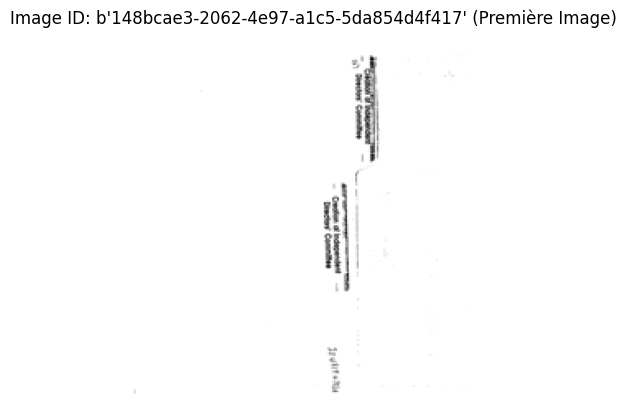

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def display_first_image(dataset):
    """
    Affiche la première image du dataset TensorFlow non batché.

    :param dataset: tf.data.Dataset, le dataset contenant les images.
    """
    # Itérer sur le dataset et prendre le premier élément
    for inputs, labels in dataset.take(1):
        # Extraire l'image et son ID
        image = inputs['image'].numpy()          # Forme : (hauteur, largeur, canaux)
        image_ID = inputs['image_ID'].numpy()    # ID de l'image

        # Si les images sont normalisées (par exemple entre -1 et 1), les ramener entre 0 et 1
        if image.min() < 0:
            image = (image + 1.0) / 2.00

        # Vérifier le nombre de canaux et ajuster pour l'affichage
        if image.shape[-1] == 1:
            # Image en niveaux de gris
            image = image.squeeze(-1)  # Supprimer le dernier axe
            cmap = 'gray'
        else:
            # Image en couleur (assumer RGB)
            cmap = None

        # Afficher l'image
        plt.imshow(image, cmap=cmap)
        plt.title(f"Image ID: {image_ID} (Première Image)")
        plt.axis('off')  # Masquer les axes
        plt.show()

        # Sortir de la boucle après avoir affiché la première image
        break

# Exemple d'utilisation
display_first_image(final_train_dataset)
